# Forward Stagewise GLM Debugging Notebook

Test out basic least squares regression with BoostedLinearModel class implementation.

In [1]:
import numpy as np
import pandas as pd
import patsy
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.base import clone as clone_model

from genestboost import BoostedLinearModel
from genestboost.weak_learners import SimplePLS
from genestboost.link_functions import LogitLink, CLogLogLink
from genestboost.loss_functions import LogLoss

%matplotlib inline

### Create Fake Dataset for Classification

In [2]:
X, y = make_classification(n_samples=65000,
                           n_features=30,
                           n_informative=5,
                           weights=(0.98, 0.02),
                           random_state=0)
X = scale(X)

### Test 1: Logit Link with Log Loss

154


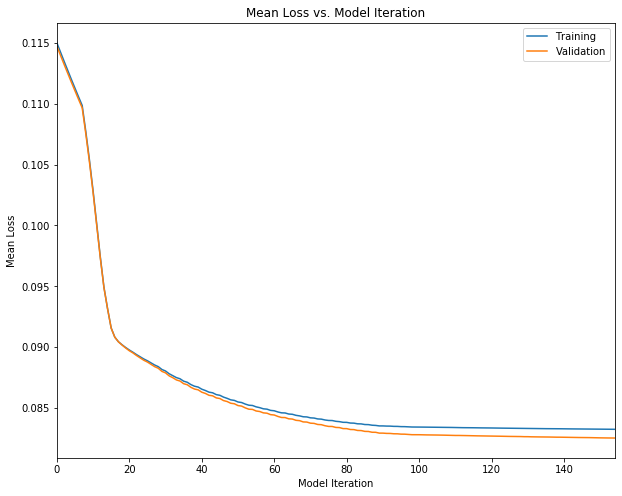

In [3]:
model = BoostedLinearModel(link=LogitLink(),
                           loss=LogLoss(),
                           model_callback=SimplePLS,
                           model_callback_kwargs={"max_vars": 3,
                                                  "filter_threshold": 0.80},
                           alpha=1.0,
                           step_type="decaying",
                           step_decay_factor=0.5,
                           weights="newton",
                           random_state=23,
                           tol=1e-8,
                           validation_fraction=0.15,
                           validation_stratify=True,
                           validation_iter_stop=10)
model.fit(X, y, iterations=2000)

# plot loss to make sure it is decreasing
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
pd.DataFrame(model.get_loss_history(),
             columns=["Training", "Validation"]).plot(ax=ax)
ax.set_title("Mean Loss vs. Model Iteration")
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Mean Loss");

print(model.get_iterations())

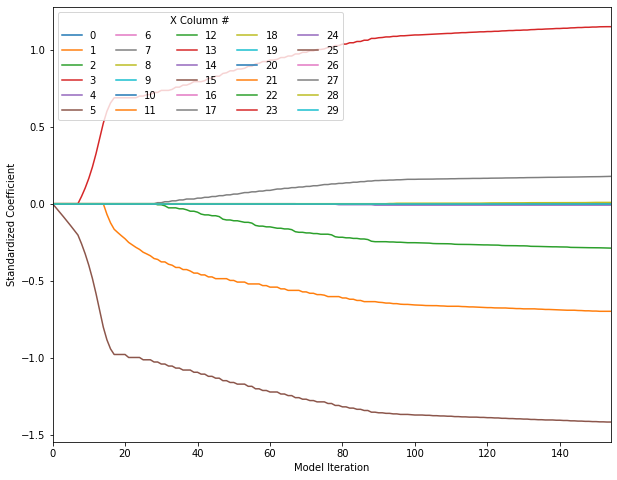

In [4]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
coef_history = pd.DataFrame(model.get_coefficient_history(scale=X.std(axis=0, ddof=1)))
coef_history.plot(ax=ax)
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Standardized Coefficient")
ax.legend(title="X Column #", loc="best", ncol=5);

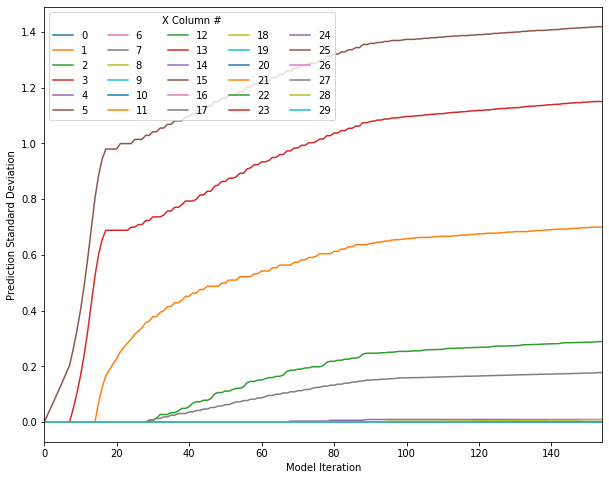

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
coef_std_history = pd.DataFrame(np.sqrt(model.get_prediction_var_history(X)))
coef_std_history.plot(ax=ax)
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Prediction Standard Deviation")
ax.legend(title="X Column #", loc="best", ncol=5);

In [6]:
print(model.get_coefficient_order())

[15, 13, 21, 2, 7, 24, 28]


### Test 2: Same as Test 1 but with CLogLogLink

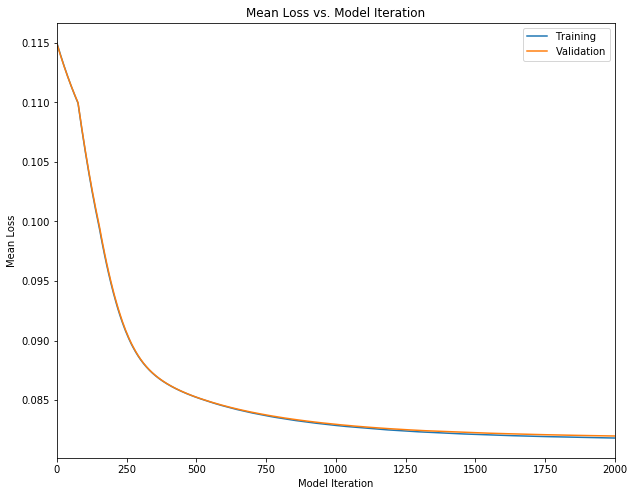

In [7]:
model = BoostedLinearModel(link=CLogLogLink(),
                           loss=LogLoss(),
                           model_callback=SimplePLS,
                           model_callback_kwargs={"max_vars": 3,
                                                  "filter_threshold": 0.80},
                           alpha=0.1,
                           step_type="constant",
                           step_decay_factor=0.5,
                           weights="none",
                           random_state=23,
                           tol=1e-8,
                           validation_fraction=0.20,
                           validation_stratify=True,
                           validation_iter_stop=5)
model.fit(X, y, iterations=2000)

# plot loss to make sure it is decreasing
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
pd.DataFrame(model.get_loss_history(),
             columns=["Training", "Validation"]).plot(ax=ax)
ax.set_title("Mean Loss vs. Model Iteration")
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Mean Loss");

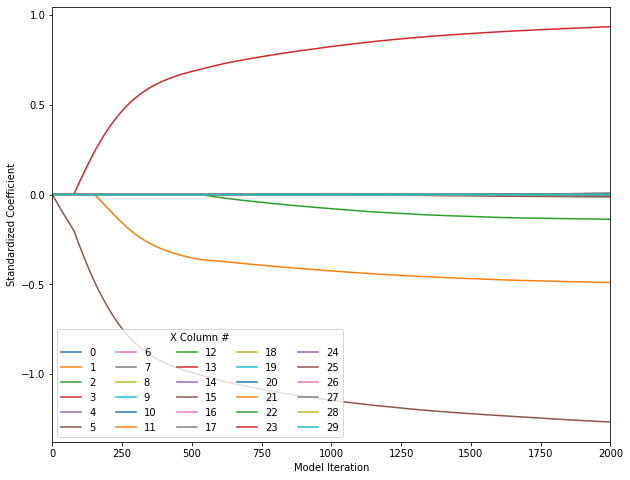

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
coef_history = pd.DataFrame(model.get_coefficient_history(scale=X.std(axis=0, ddof=1)))
coef_history.plot(ax=ax)
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Standardized Coefficient")
ax.legend(title="X Column #", loc="best", ncol=5);

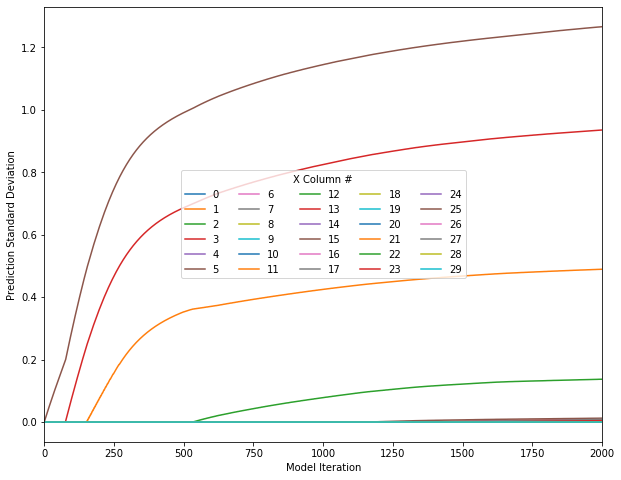

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
coef_std_history = pd.DataFrame(np.sqrt(model.get_prediction_var_history(X)))
coef_std_history.plot(ax=ax)
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Prediction Standard Deviation")
ax.legend(title="X Column #", loc="best", ncol=5);

In [10]:
model.get_coefficient_order()

[15, 13, 21, 2, 5, 3, 17, 6, 23, 7, 19]

### Test 3: Spline Logistic Regression

In [11]:
# load data
iris_dict = load_iris()
X = iris_dict["data"]
X_spline = (patsy
            .dmatrix("cr(x, df=3)", data={"x": X[:, 2]}, NA_action='drop', return_type='dataframe')
            .values)
y = 1 * (iris_dict["target"] == 1)

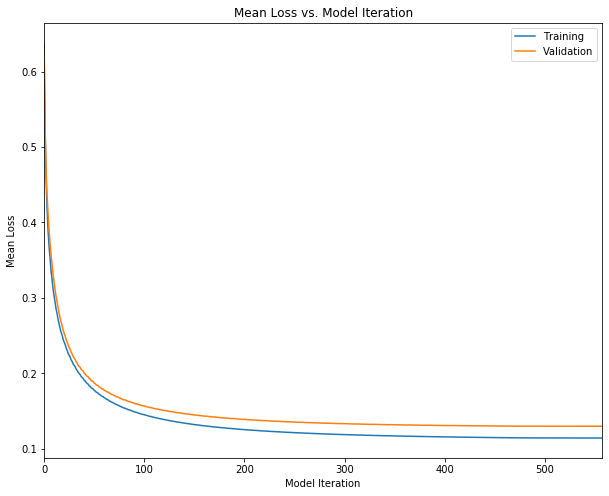

In [12]:
# fit model
model = BoostedLinearModel(link=LogitLink(),
                            loss=LogLoss(),
                           model_callback=SimplePLS,
                            alpha=1.0,
                            step_type="decaying",
                            step_decay_factor=0.5,
                            weights="newton",
                            random_state=47,
                            tol=1e-12,
                            validation_fraction=0.15,
                            validation_stratify=True,
                            validation_iter_stop=10)
model.fit(X_spline, y, iterations=2000)

# plot loss to make sure it is decreasing
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
pd.DataFrame(model.get_loss_history(),
             columns=["Training", "Validation"]).plot(ax=ax)
ax.set_title("Mean Loss vs. Model Iteration")
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Mean Loss");

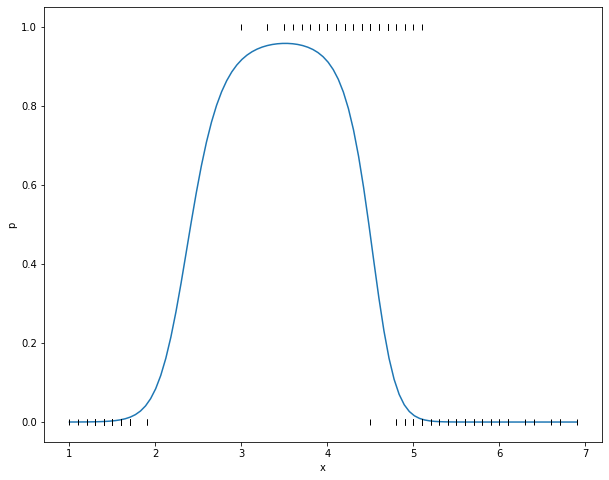

In [13]:
x = np.linspace(X[:, 2].min(), X[:, 2].max(), num=101)
x_spline = (patsy
            .dmatrix("cr(x, df=3)", data={"x": x}, NA_action='drop', return_type='dataframe')
            .values)
preds = model.predict(x_spline)
plt.plot(x, preds)
ax = plt.gca()
ax.plot(X[:, 2], y, marker="|", linestyle="none", color="black")
fig = ax.get_figure()
ax.set_xlabel("x")
ax.set_ylabel("p")
fig.set_figheight(8)
fig.set_figwidth(10);